In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import graphlab as gl
from graphlab.toolkits.feature_engineering import TFIDF, FeatureHasher, QuadraticFeatures

gl.canvas.set_target('ipynb')

PATH_TO_JSON = "docs_prod_03/"
PATH_TO_TRAIN_LABELS = "input/train.csv"
PATH_TO_TEST_LABELS = "input/sampleSubmission.csv"

[WARNING] This Python session does not appear to be running in an interactive IPython Notebook. Use of the 'ipynb' target may behave unexpectedly or result in errors.


### Read processed documents

In [2]:
# documents
sf = gl.SFrame.read_csv(PATH_TO_JSON, header=False, verbose=False)
sf = sf.unpack('X1',column_name_prefix='')
sf['id'] = sf['id'].apply(lambda x: str(x.split('_')[0] ))

[INFO] This trial license of GraphLab Create is assigned to renatbek@gmail.com and will expire on October 08, 2015. Please contact trial@dato.com for licensing options or to request a free non-commercial license for personal or academic use.

[INFO] Start server at: ipc:///tmp/graphlab_server-5504 - Server binary: /usr/local/lib/python2.7/site-packages/graphlab/unity_server - Server log: /tmp/graphlab_server_1442639022.log
[INFO] GraphLab Server Version: 1.5.2


------------------------------------------------------
Inferred types from first line of file as 
column_type_hints=[dict]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------
PROGRESS: Finished parsing file /mnt/data/docs_prod_03/20
PROGRESS: Read 5681 lines. Lines per second: 12762.7
PROGRESS: Finished parsing file /mnt/data/docs_prod_03/7
PROGRESS: Finished parsing file /mnt/data/docs_prod_03/24
PROGRESS: Finished parsing file /mnt/data/docs_prod_03/2
PROGRESS: Finished parsing file /mnt/data/docs_prod_03/0
PROGRESS: Finished parsing file /mnt/data/docs_prod_03/54
PROGRESS: Finished parsing file /mnt/data/docs_prod_03/51
PROGRESS: Finished parsing file /mnt/data/docs_prod_03/42
PROGRESS: Finished parsing file /mnt/data/docs_prod_03/67
PROGRESS: Finished parsing file /mnt/data/docs_prod_03/44
PROGRESS: Finished parsing file /mnt/data/docs_p

### Read train/test labels and merge into documents

In [3]:
# train/test labels
train_labels = gl.SFrame.read_csv(PATH_TO_TRAIN_LABELS, verbose=False)
test_labels = gl.SFrame.read_csv(PATH_TO_TEST_LABELS, verbose=False)
train_labels['id'] = train_labels['file'].apply(lambda x: str(x.split('_')[0] ))
train_labels = train_labels.remove_column('file')
test_labels['id'] = test_labels['file'].apply(lambda x: str(x.split('_')[0] ))
test_labels = test_labels.remove_column('file')

# join
train = train_labels.join(sf, on='id', how='left')
test = test_labels.join(sf, on='id', how='left')

------------------------------------------------------
Inferred types from first line of file as 
column_type_hints=[str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------
PROGRESS: Finished parsing file /mnt/data/input/train.csv
PROGRESS: Parsing completed. Parsed 337024 lines in 0.106357 secs.
------------------------------------------------------
Inferred types from first line of file as 
column_type_hints=[str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------
PROGRESS: Finished parsing file /mnt/data/input/sampleSubmission.csv
PROGRESS: Parsing completed. Parsed 66772 lines in 0.040573 secs.


### Generate BOW

In [4]:
bow_trn = gl.text_analytics.count_words(train['text'])
bow_trn = bow_trn.dict_trim_by_keys(gl.text_analytics.stopwords())

bow_tst = gl.text_analytics.count_words(test['text'])
bow_tst = bow_tst.dict_trim_by_keys(gl.text_analytics.stopwords())

train['bow'] = bow_trn
test['bow'] = bow_tst

### Generate TF-IDF

In [6]:
encoder = gl.feature_engineering.create(train, TFIDF('bow', output_column_name='tfidf', min_document_frequency=1e-5))
train = encoder.transform(train)
test = encoder.transform(test)

### Hash TF-IDF

In [10]:
hash_encoder = gl.feature_engineering.create(train, FeatureHasher(features = ['tfidf'], num_bits=16, 
                                                                  output_column_name='tfidf_hashed'))
train['tfidf_hashed'] = hash_encoder.transform(train)['tfidf_hashed']
test['tfidf_hashed'] = hash_encoder.transform(test)['tfidf_hashed']

# Generate Submission Model

In [ ]:
model = gl.logistic_classifier.create(train, target='sponsored', 
                                      features=['tfidf_hashed'],
                                      validation_set=None,
                                      class_weights='auto',
                                      max_iterations=10,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
svm_model = gl.svm_classifier.create(train, target='sponsored', 
                                      features=['tfidf_hashed'],
                                      validation_set=None,                                           
                                      class_weights='auto',
                                      max_iterations=20)

### Output model

In [ ]:
ypred = model.predict(test, 'probability')

submission = gl.SFrame()
submission['file'] = test['id'].apply(lambda x: x + '_raw_html.txt')
submission['sponsored'] = ypred 
submission.save('submission_version_4.csv', format='csv')

submission = submission.to_dataframe()
submission.to_csv('submission_version_4.csv', index=False, float_format='%1.8f')

# Experiment

### Split train into *train_train*/*train_cv*

In [11]:
train_train, train_cv = train.random_split(0.80, seed=107)

In [15]:
model = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed'],
                                      validation_set=train_cv,
                                      class_weights='auto',
                                      max_iterations=20,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

[ERROR] Toolkit error: Cancelled by user.


PROGRESS: Logistic regression:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 269988
PROGRESS: Number of classes           : 2
PROGRESS: Number of feature columns   : 1
PROGRESS: Number of unpacked features : 65464
PROGRESS: Number of coefficients    : 65465
PROGRESS: Starting L-BFGS
PROGRESS: --------------------------------------------------------
PROGRESS: +-----------+----------+-----------+--------------+-------------------+---------------------+
PROGRESS: | Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |
PROGRESS: +-----------+----------+-----------+--------------+-------------------+---------------------+
PROGRESS: | 1         | 3        | 0.000004  | 2.825236     | 0.635110          | 0.628811            |
PROGRESS: | 2         | 5        | 1.000000  | 4.782627     | 0.909074          | 0.897607            |
PROGRESS: | 3         | 6        | 1.000000  | 6.240513     | 0.8955

ToolkitError: Cancelled by user.

In [ ]:
model.evaluate(train_cv)

In [ ]:
results = model.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [16]:
svm_model = gl.svm_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed'],
                                      validation_set=train_cv,                                           
                                      class_weights='auto',
                                      max_iterations=10)

PROGRESS: SVM:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 269988
PROGRESS: Number of classes           : 2
PROGRESS: Number of feature columns   : 1
PROGRESS: Number of unpacked features : 65464
PROGRESS: Number of coefficients    : 65465
PROGRESS: Starting L-BFGS
PROGRESS: --------------------------------------------------------
PROGRESS: +-----------+----------+-----------+--------------+-------------------+---------------------+
PROGRESS: | Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |
PROGRESS: +-----------+----------+-----------+--------------+-------------------+---------------------+
PROGRESS: | 1         | 3        | 0.000004  | 1.984194     | 0.635110          | 0.628811            |
PROGRESS: | 2         | 5        | 1.000000  | 3.969712     | 0.912744          | 0.901605            |
PROGRESS: | 3         | 6        | 1.000000  | 5.314774     | 0.904199          | 0.

In [18]:
train_cv['margin'] = svm_model.predict(train_cv, output_type='margin')

In [24]:
preds = train_cv[['sponsored', 'margin']]

In [27]:
preds['margin'].show()

In [43]:
preds = preds.sort('margin')

In [53]:
pd_preds_cum = pd_preds.cumsum()

In [77]:
np.asarray(pd_preds_cum['number'])[-1]

67036.0

hello


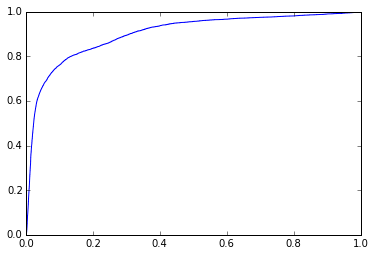

In [80]:
preds = preds.sort('margin')

pd_preds = preds.to_dataframe()
pd_preds['number'] = 1.0

pd_preds_cum = pd_preds.cumsum()

total_positives = np.asarray(pd_preds_cum['sponsored'])[-1]
total = np.asarray(pd_preds_cum['number'])[-1]
total_negatives = total - total_positives

pd_preds_cum['FN'] = pd_preds_cum['sponsored']
pd_preds_cum['TN'] = pd_preds_cum['number'] - pd_preds_cum['sponsored']

pd_preds_cum['TP'] = total_positives - pd_preds_cum['FN']
pd_preds_cum['FP'] = total - total_positives - pd_preds_cum['TN']
#pd_preds_cum['FP'] = 67036 - 6630 - pd_preds_cum['TN']

pd_preds_cum['fpr'] = pd_preds_cum['FP'] / (pd_preds_cum['FP'] + pd_preds_cum['TN'])
pd_preds_cum['tpr'] = pd_preds_cum['TP'] / (pd_preds_cum['TP'] + pd_preds_cum['FN'])

plt.plot(pd_preds_cum['fpr'], pd_preds_cum['tpr'])


In [55]:
pd_preds_cum.head()

,sponsored,margin,number
0,0,-594.778066,1
1,0,-945.768237,2
2,0,-1279.156755,3
3,0,-1522.029844,4
4,0,-1702.560645,5


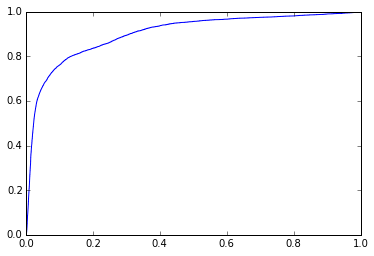

In [69]:
plt.plot(pd_preds_cum['fpr'], pd_preds_cum['tpr'])

In [46]:
preds.head()

sponsored,margin,number
0,-594.778066196,1.0
0,-350.990171129,1.0
0,-333.388517796,1.0
0,-242.873088385,1.0
0,-180.530801115,1.0
0,-171.040876568,1.0
0,-156.054032664,1.0
0,-151.616596792,1.0
0,-141.75301252,1.0
0,-128.849399732,1.0


In [39]:
(preds[preds['margin'] < 55]['sponsored']).sum()

6627

In [25]:
ts = np.arange(-22, 50, 0.1)
[for t in ts]

sponsored,margin
0,-2.9126437726
0,-1.16004881947
0,-3.2681065082
0,-0.472531142735
1,2.08854632575
0,-4.16111867912
0,-4.45363386806
0,-4.76737951841
0,-0.745311905408
0,-1.46049804152


In [ ]:
svm_model.evaluate(train_cv)

In [ ]:
results = svm_model.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
results

# Save Datasets?

In [ ]:
train_train.save('dataset_train_train')
train_cv.save('dataset_train_cv')
test.save('dataset_test')

# Junk

In [ ]:
hash_encoder = gl.feature_engineering.create(train_train, FeatureHasher(features = ['tfidf'], num_bits=17, 
                                                                  output_column_name='tfidf_hashed_17'))
train_train['tfidf_hashed_17'] = hash_encoder.transform(train_train)['tfidf_hashed_17']
train_cv['tfidf_hashed_17'] = hash_encoder.transform(train_cv)['tfidf_hashed_17']

In [ ]:
train_train.head()

In [ ]:
model_15 = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_15'],
                                      validation_set=train_cv,
                                      class_weights='auto',
                                      max_iterations=40,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
model_15

In [ ]:
model_15.evaluate(train_cv)

In [ ]:
results = model_15.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
model_16 = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_16'],
                                      validation_set=train_cv,
                                      class_weights='auto',
                                      max_iterations=20,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
model_16.evaluate(train_cv)

In [ ]:
results = model_16.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
model_17 = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_17'],
                                      validation_set=train_cv,
                                      class_weights=None, #'auto',
                                      max_iterations=8,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
model_17 = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_17'],
                                      validation_set=train_cv,
                                      class_weights=None, #'auto',
                                      max_iterations=7,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
model_17.evaluate(train_cv)

In [ ]:
results = model_17.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
gl.svm_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_15'],
                                      validation_set=train_cv,                                           
                                      class_weights='auto',
                                      max_iterations=40)

In [ ]:
gl.svm_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_16'],
                                      validation_set=train_cv,                                           
                                      class_weights='auto',
                                      max_iterations=40)

In [ ]:
gl.svm_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_17'],
                                      validation_set=train_cv,                                           
                                      class_weights='auto',
                                      max_iterations=40)

In [12]:
train.head()

sponsored,id,text,bow,tfidf
1,2231023,cruis consid ourselvultim resourc cruis deal ...,"{'haggl': 1, 'forget': 1,'celebr': 12, 'eldest': ...","{'haggl':7.2854917128941326, ..."
0,2231034,fabric err lhumourbeaucoup enseign dan ...,"{'quotidien': 1, 'bzier':1, 'seul': 1, 'lutter': ...","{'quotidien':7.194519934688406, ..."
0,223104,age skin sever problemwhich make individu look ...,"{'alo': 1, 'nutrit': 2,'gradual': 1, 'lack': 2, ...","{'alo':6.505333155344558, ..."
0,2231053,welcom sign homepagaol.com channel homepag ...,"{'summer': 2, 'mexican':2, 'feedback': 1, 'sh ...","{'summer':4.416257474360147, ..."
0,2231062,your messag been sentcoub.com blog ...,"{'blog': 1, 'messag': 1,'coub.com': 1} ...","{'blog':1.0534690327911476, ..."
0,2231072,ford black front anglimag copyright seriou ...,"{'wheel': 2, 'copyright':1, 'pictur': 1, 'angl': ...","{'wheel':7.251199591306898, ..."
0,2231088,,{},{}
0,2231095,latest addit corpor stablmodel famili allow user ...,"{'parentnod': 2, 'text':1, 'laptop': 6, 'disc': ...","{'parentnod':8.4968361983674, 'text': ..."
0,2231104,pectin from ancientgreekpktik congeal curdl ...,"{'partial': 1, 'chain':4, 'woodi': 1, ...","{'partial':4.294315255876003, ..."
0,2231119,powder alcohol advancsearch googl imag home ...,"{'shop': 1, 'feedback':1, 'photo': 1, 'prefer': ...","{'shop':1.7292320990130188, ..."


In [13]:
train.save('tfidf_hashed_16_train')
test.save('tfidf_hashed_16_test')

In [14]:
train_train.save('tfidf_hashed_16_split_train_train')
train_cv.save('tfidf_hashed_16_split_train_cv')